In [33]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import h5py
%matplotlib inline

mat_names = glob.glob('./project_datasets/*.mat')
# each test subject got a different file - 9 test subjects
print(mat_names)

['./project_datasets/A07T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A01T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A09T_slice.mat']


In [14]:
matfile = h5py.File(mat_names[0], 'r')
print(matfile.keys()) #image and type

[u'image', u'type']


In [27]:
image_mat = matfile['image']
image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)

(288, 25, 1000)

In [26]:
type_mat = matfile['type']
type_mat.shape
# plt.plot(type_mat[0,:288]) # gets the significant values of types
# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

(1, 1000)

In [20]:
nans = np.sum(np.isnan(image_mat[:,:]))
print(nans) #No NaN in the data

0


In [23]:
type_set = set(type_mat[0,:])
print(type_set) 

set([0.0, 769.0, 770.0, 771.0, 772.0])


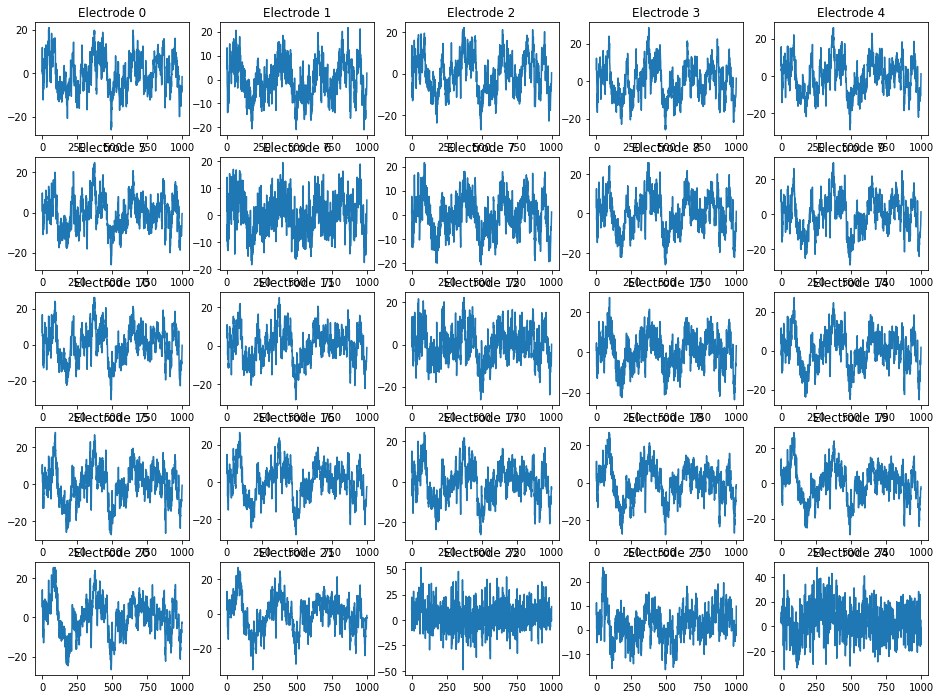

In [38]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(matfile['image'][0,i,:])
    plt.title("Electrode " + str(i))
    plt.rcParams["figure.figsize"] = [20,20]